# Analysis for Climate Discourse paper

This notebook contains the analysis for the 'substantive' paper

In [27]:
import pandas as pd
import math
import numpy as np
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf


# Dataset overview and datawrangling

In [2]:
df = pd.read_csv('../data/annotations/twitter_klimaat_discussie_coderingen.csv')

In [3]:
## number of unique annotators:

In [4]:
len(df['coder'].unique())

1517

<AxesSubplot:>

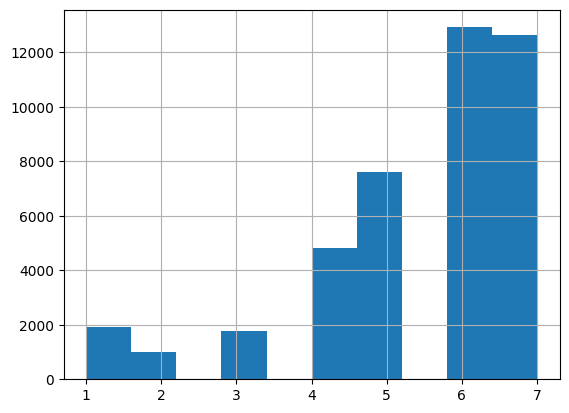

In [5]:
df['scientific_consensus.pro_klimaat'].hist()

In [6]:
df['comment_inhoudelijk_argument'].value_counts()
#df.info()

comment_inhoudelijk_argument
Geen inhoudelijk argument    21428
Inhoudelijk argument         21416
Name: count, dtype: int64

## Remove missing obs

In [7]:
print(len(df))
df = df.dropna(subset=['scientific_consensus.pro_klimaat'])
df = df.dropna(subset=['age'])
df = df.dropna(subset=['gender'])
df = df.dropna(subset=['comment_respectvol'])
print(len(df))

42844
42483


In [8]:
len(df['coder'].unique())

1504

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42483 entries, 0 to 42843
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   coder                                      42483 non-null  int64  
 1   jobset                                     42483 non-null  object 
 2   scientific_consensus.pro_klimaat           42483 non-null  float64
 3   scientific_consensus.belangrijk_onderwerp  42483 non-null  float64
 4   scientific_consensus.sterke_mening         42483 non-null  float64
 5   scientific_consensus.interesse_klimaat     42483 non-null  float64
 6   age                                        42483 non-null  float64
 7   gender                                     42483 non-null  object 
 8   education                                  42483 non-null  object 
 9   workhours                                  42483 non-null  object 
 10  tweet_id                   

## Internal consistency of the *issue importance* scale

In [10]:
# Specify the columns for which you want to calculate Cronbach's alpha
selected_columns = ['scientific_consensus.belangrijk_onderwerp',
                    'scientific_consensus.sterke_mening',
                    'scientific_consensus.interesse_klimaat']

# Group by 'coder_id' and calculate Cronbach's alpha for selected columns
grouped_data = df.groupby('coder')[selected_columns].first()

# Calculate Cronbach's alpha for the selected columns
alpha_result = pg.cronbach_alpha(grouped_data)
alpha_result

(0.8076223379196215, array([0.79 , 0.824]))

In [11]:
# Create a new column 'average_score' that contains the average of the specified columns
df['scale_importance'] = df[selected_columns].mean(axis=1)
# Display the result

In [12]:
#df[df['tweet_pro_klimaat'] == 'Eens']
df['comment_pro_klimaat'].value_counts()

comment_pro_klimaat
Nee         15183
Ja          14927
Neutraal    12373
Name: count, dtype: int64

In [13]:
df['gender'].value_counts()

gender
Vrouw                        22213
Man                          19979
Non-binary                     181
Wil ik liever niet zeggen      110
Name: count, dtype: int64

In [14]:
df['comment_respectvol'].value_counts()

comment_respectvol
Eens      29186
Oneens    13297
Name: count, dtype: int64

## recoding variables

In [15]:
# Create two dummy variables for 'comment_pro_klimaat'
dummy_variables = pd.get_dummies(df['comment_pro_klimaat'], prefix='comment_pro_klimaat')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

df[['coder', 'comment_pro_klimaat', 'comment_pro_klimaat_Ja', 'comment_pro_klimaat_Nee']]. head(6)

,coder,comment_pro_klimaat,comment_pro_klimaat_Ja,comment_pro_klimaat_Nee
0,11,Ja,1,0
1,11,Ja,1,0
2,11,Ja,1,0
3,11,Neutraal,0,0
4,11,Neutraal,0,0
5,11,Neutraal,0,0


In [16]:
df['tweet_pro_klimaat'].value_counts()

recode_mapping = {'Eens': 'Ja', 'Oneens': 'Nee'}

# Recode 'tweet_pro_klimaat'
df['tweet_pro_klimaat'] = df['tweet_pro_klimaat'].replace(recode_mapping)

dummy_variables = pd.get_dummies(df['tweet_pro_klimaat'], prefix='tweet_pro_klimaat')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

In [17]:
# Create two dummy variables for 'comment_pro_klimaat'
dummy_variables = pd.get_dummies(df['comment_respectvol'], prefix='comment_respectvol')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

In [18]:
df['coder'] = df['coder'].astype(str)

In [19]:
# Mapping of categories to two groups
gender_mapping = {
    'Vrouw': 'Female',
    'Man': 'Male',
    'Non-binary': 'Other',
    'Wil ik liever niet zeggen': 'Other'
}

df['recoded_gender'] = df['gender'].map(gender_mapping)

df['male_dummy'] = (df['recoded_gender'] == 'Male').astype(int)
df['female_dummy'] = (df['recoded_gender'] == 'Female').astype(int)

In [20]:
df['comment_inhoudelijk_argument_Ja'] = (df['comment_inhoudelijk_argument'] == 'Inhoudelijk argument').astype(int)
df['comment_persoonlijke_aanval_Ja'] = (df['comment_persoonlijke_aanval'] == 'Persoonlijke aanval').astype(int)
df['comment_respectvol_Ja'] = (df['comment_respectvol'] == 'Eens').astype(int)
df['comment_over_communicatie_Ja'] = (df['comment_over_communicatie'] == 'Eens').astype(int)


In [21]:
education_mapping = {
    'Voorbereidend of kort middelbaar beroepsonderwijs (VMBO, KMBO)': 'Lager',
    'Hoger beroepsonderwijs (HBO, HTS, HEAO, Sociale Academie, HHNO, lerarenonderwijs, etc.': 'Hoger',
    'Middelbaar beroepsonderwijs (MBO, MTS, MEAO, Praktijkdiploma Boekhouden, Kleuterkweekschool, etc.': 'Lager',
    'Anders': 'Lager',
    'Wetenschappelijk onderwijs (universiteit)': 'Hoger',
    'Voortgezet algemeen onderwijs (5-jaar HBS, MMS, HAVO, Lyceum, Atheneum, Gymnasium, VWO, etc.': 'Lager',
    'Lager beroepsonderwijs (LBO, LTS, LHNO, huishoud-/ambachts-school, LEAO, lage land-en tuinbouwonderwijs etc.)': 'Lager',
    'Middelbaar algemeen onderwijs (LAVO, ULO, MULO, MAVO, 3-jaar HBS, etc)': 'Lager',
    'Lagere school (basisonderwijs)': 'Lager',
    'Geen onderwijs of niet afgemaakt': 'Lager'
}

# Recode 'education' into a new column 'recoded_education'
df['recoded_education'] = df['education'].map(education_mapping)
df['recoded_education_hoger'] = (df['recoded_gender'] == 'Hoger').astype(int)

In [22]:
df[['tweet_id', 'jobset', 'comment_nr']].head(10)

,tweet_id,jobset,comment_nr
0,22,set_3,1
1,22,set_3,2
2,22,set_3,3
3,22,set_3,4
4,22,set_3,5
5,24,set_3,1
6,24,set_3,2
7,24,set_3,3
8,24,set_3,4
9,24,set_3,5


In [23]:
df['scientific_consensus_pro_klimaat'] = df['scientific_consensus.pro_klimaat']

## RUnning some models

In [24]:

# Fit a logistic mixed-effects regression model
formula = 'comment_pro_klimaat_Nee ~ age + male_dummy + recoded_education + scientific_consensus_pro_klimaat '
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Max

                   Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   comment_pro_klimaat_Nee
No. Observations:   42483     Method:               REML                   
No. Groups:         1504      Scale:                0.1667                 
Min. group size:    11        Log-Likelihood:       -24860.8587            
Max. group size:    34        Converged:            No                     
Mean group size:    28.2                                                   
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.371    0.052  7.125 0.000  0.269  0.473
recoded_education[T.Lager]       -0.054    0.021 -2.520 0.012 -0.096 -0.012
age                               0.002    0.001  2.548 0.011  0.000  0.003
male_dummy                     

In [29]:
# also just run an ordinary logistic regression, to just get a rough idea
# in particular given that all 

dvs = ['comment_pro_klimaat_Nee', 'comment_inhoudelijk_argument_Ja',
       'comment_persoonlijke_aanval_Ja', 'comment_over_communicatie_Ja', 'comment_respectvol_Ja']
for dv in dvs:
    print(dv)
    print('*'*50)
    formula = f'{dv} ~ age + male_dummy + recoded_education + scientific_consensus_pro_klimaat '
    r = smf.logit(formula, df, groups=df['coder']).fit()
    print(r.params.apply(math.exp)[1:])
    print('\n\n')

comment_pro_klimaat_Nee
**************************************************
Optimization terminated successfully.
         Current function value: 0.647926
         Iterations 4


/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


recoded_education[T.Lager]          0.798859
age                                 1.007334
male_dummy                          1.056337
scientific_consensus_pro_klimaat    0.937053
dtype: float64



comment_inhoudelijk_argument_Ja
**************************************************


/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.690703
         Iterations 4
recoded_education[T.Lager]          1.330244
age                                 1.000117
male_dummy                          1.052937
scientific_consensus_pro_klimaat    1.018266
dtype: float64



comment_persoonlijke_aanval_Ja
**************************************************


/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.654804
         Iterations 4
recoded_education[T.Lager]          1.369864
age                                 0.992040
male_dummy                          1.051646
scientific_consensus_pro_klimaat    1.045560
dtype: float64



comment_over_communicatie_Ja
**************************************************


/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.681635
         Iterations 4
recoded_education[T.Lager]          1.449360
age                                 1.009967
male_dummy                          1.050358
scientific_consensus_pro_klimaat    1.042381
dtype: float64



comment_respectvol_Ja
**************************************************
Optimization terminated successfully.
         Current function value: 0.620272
         Iterations 5
recoded_education[T.Lager]          0.887617
age                                 1.000094
male_dummy                          1.071174
scientific_consensus_pro_klimaat    1.046420
dtype: float64





/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [30]:
# Fit a logistic mixed-effects regression model
formula = 'comment_pro_klimaat_Nee ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat + comment_respectvol_Eens + comment_nr'
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Max

                   Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   comment_pro_klimaat_Nee
No. Observations:    42483     Method:               REML                   
No. Groups:          1504      Scale:                0.1639                 
Min. group size:     11        Log-Likelihood:       -24714.8851            
Max. group size:     34        Converged:            No                     
Mean group size:     28.2                                                   
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.491    0.066   7.477 0.000  0.362  0.620
recoded_education[T.Lager]       -0.063    0.025  -2.510 0.012 -0.112 -0.014
age                               0.002    0.001   2.451 0.014  0.000  0.003
male_dummy         

In [32]:
# Fit a logistic mixed-effects regression model
formula = 'comment_respectvol_Eens ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat * comment_pro_klimaat_Nee + comment_nr'
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Max

                               Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           comment_respectvol_Eens
No. Observations:           42483             Method:                       REML                   
No. Groups:                 1504              Scale:                        0.1772                 
Min. group size:            11                Log-Likelihood:               -25222.5107            
Max. group size:            34                Converged:                    No                     
Mean group size:            28.2                                                                   
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

In [33]:
df[['comment_pro_klimaat_Ja', 'comment_pro_klimaat']]

,comment_pro_klimaat_Ja,comment_pro_klimaat
0,1,Ja
1,1,Ja
2,1,Ja
3,0,Neutraal
4,0,Neutraal
...,...,...
42839,0,Nee
42840,0,Nee
42841,0,Nee
42842,0,Nee


In [34]:
# Fit a logistic mixed-effects regression model
formula = 'comment_respectvol_Eens ~ scientific_consensus_pro_klimaat * comment_pro_klimaat_Ja'
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          comment_respectvol_Eens
No. Observations:            42483            Method:                      REML                   
No. Groups:                  1504             Scale:                       0.1789                 
Min. group size:             11               Log-Likelihood:              -25102.6732            
Max. group size:             34               Converged:                   Yes                    
Mean group size:             28.2                                                                 
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

In [35]:
interaction_data = pd.DataFrame({
    'scientific_consensus_pro_klimaat': np.linspace(df['scientific_consensus_pro_klimaat'].min(),
                                                    df['scientific_consensus_pro_klimaat'].max(), 100),
    'comment_pro_klimaat_Ja': [0, 1] * 50,  # Two levels for interaction
})

predicted_probs = result.predict(interaction_data)

sns.set(style='whitegrid')

# Create a more visually appealing interaction plot
plt.figure(figsize=(14, 10))
sns.lineplot(x='scientific_consensus_pro_klimaat', y=predicted_probs, hue='comment_pro_klimaat_Ja', data=interaction_data,
             palette=sns.color_palette('Set2'), linewidth=2)

# Set plot title and labels
plt.title('Interaction Effect: Scientific Consensus on Human-Caused Climate Change and Comment Tone', fontsize=16)
plt.xlabel('Scientific Consensus on Human-Caused Climate Change', fontsize=14)
plt.ylabel('Predicted Probability of Respectful Tone in Comment', fontsize=14)

# Customize legend
plt.legend(title='Comment Tone (0 = Neutral or Denial, 1 = Climate change is real)', fontsize=12, title_fontsize=14)

# Display the plot
plt.show()


ValueError: The palette list has the wrong number of colors.

<Figure size 1400x1000 with 0 Axes>

In [37]:

# Assuming 'result' is your fitted model result
# Replace this with your actual result

# Generate data for interaction plot
interaction_data = pd.DataFrame({'scientific_consensus_pro_klimaat': np.linspace(df['scientific_consensus_pro_klimaat'].min(),
                                                                               df['scientific_consensus_pro_klimaat'].max(), 100),
                                 'comment_pro_klimaat_Nee': [0, 1] * 50,  # Two levels for interaction
                                 'male_dummy': df['male_dummy'].mean(),  # Mean value for other variables
                                 'recoded_education': df['recoded_education_hoger'].mean(),
                                 'scale_importance': df['scale_importance'].mean(),
                                 'age': df['age'].mean(),
                                 'comment_nr': df['comment_nr'].mean()})

# Predict probabilities for each level of the interacting variables
predicted_probs = result.predict(interaction_data)

# Create interaction plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='scientific_consensus_pro_klimaat', y=predicted_probs, hue='comment_pro_klimaat_Nee', data=interaction_data)
plt.title('Interaction Effect: scientific_consensus_pro_klimaat * comment_pro_klimaat_Nee')
plt.xlabel('scientific_consensus_pro_klimaat')
plt.ylabel('Predicted Probability of comment_respectvol_Eens')
plt.legend(title='comment_pro_klimaat_Nee')
plt.show()


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'comment_pro_klimaat_Ja' is not defined
    comment_respectvol_Eens ~ scientific_consensus_pro_klimaat * comment_pro_klimaat_Ja
                                                                 ^^^^^^^^^^^^^^^^^^^^^^

In [38]:

formula = 'comment_inhoudelijk_argument_Ja  ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat + comment_respectvol_Eens + comment_nr'
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: comment_inhoudelijk_argument_Ja
No. Observations: 42483   Method:             REML                           
No. Groups:       1504    Scale:              0.2025                         
Min. group size:  11      Log-Likelihood:     -27717.7504                    
Max. group size:  34      Converged:          Yes                            
Mean group size:  28.2                                                       
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.273    0.030  9.102 0.000  0.214  0.332
recoded_education[T.Lager]          0.082    0.011  7.468 0.000  0.061  0.104
age                                -0.000    0.000 -0.320 0.749 -0.001  0.001
male_d

In [39]:

formula = 'tweet_pro_klimaat_Nee ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat'
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   tweet_pro_klimaat_Nee
No. Observations:     42483     Method:               REML                 
No. Groups:           1504      Scale:                0.1288               
Min. group size:      11        Log-Likelihood:       -18771.4146          
Max. group size:      34        Converged:            Yes                  
Mean group size:      28.2                                                 
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.277    0.036  7.580 0.000  0.205  0.348
recoded_education[T.Lager]       -0.059    0.014 -4.344 0.000 -0.086 -0.033
age                               0.003    0.000  7.159 0.000  0.002  0.004
male_dummy                     

In [40]:
# Fit a logistic mixed-effects regression model
formula = 'comment_respectvol_Eens ~ age + male_dummy + recoded_education + scale_importance + scientific_consensus_pro_klimaat'
model = smf.mixedlm(formula, df, groups=df['coder'], re_formula='1 + tweet_id')
result = model.fit()

# Display the model summary
print(result.summary())

/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/damian/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/damian/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Max

                   Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   comment_respectvol_Eens
No. Observations:   42483     Method:               REML                   
No. Groups:         1504      Scale:                0.1810                 
Min. group size:    11        Log-Likelihood:       -25376.5604            
Max. group size:    34        Converged:            No                     
Mean group size:    28.2                                                   
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.625    0.029 21.751 0.000  0.569  0.681
recoded_education[T.Lager]       -0.025    0.011 -2.331 0.020 -0.046 -0.004
age                              -0.000    0.000 -0.046 0.964 -0.001  0.001
male_dummy                     